# Meshing Australia

In this notebook we:

1. Import a coastline from an ESRI shapefile
2. Sample its interior using the poisson disc generator
3. Resample the interior using a DEM
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

import shapefile
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
def remove_duplicates(a):
    """
    find unique rows in numpy array 
    <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
    """
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
    return dedup

coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
shapeRecs = coast_shape.shapeRecords()
coords = []
for record in shapeRecs:
    coords.append(record.shape.points[:])
    
coords = np.vstack(coords)

# Remove duplicates
points = remove_duplicates(coords)

In [3]:
ne_land = shapefile.Reader("data/ne_110m_land/ne_110m_land.shp")
land_shapes = ne_land.shapeRecords()

polyList = []
for i,s in  enumerate(ne_land.shapes()):
    if len(s.points) < 3:
        print "Dodgy Polygon ", i, s
    else:
        p = Polygon(s.points)
        if p.is_valid:
            polyList.append(p)
        
pAll_ne110 = MultiPolygon(polyList)
tas_poly_ne110 = 11
ausmain_poly_ne110 = 21

AusLandPolygon_ne110 = MultiPolygon([polyList[tas_poly_ne110], polyList[ausmain_poly_ne110]])


Ring Self-intersection at or near point -132.71000788443121 54.040009315423447
Self-intersection at or near point 51.862689800047512 42.980156685222781


In [80]:
ne_land = shapefile.Reader("data/ne_50m_land/ne_50m_land.shp")
land_shapes = ne_land.shapeRecords()

polyList = []
for i,s in  enumerate(ne_land.shapes()):
    if len(s.points) < 3:
        print "Dodgy Polygon ", i, s
    else:
        p = Polygon(s.points)
        if p.is_valid:
            polyList.append(p)
        
pAll_ne50 = MultiPolygon(polyList)
tas_poly_ne50 = 89
ausmain_poly_ne50 = 6

# AusLandPolygon_ne50 = MultiPolygon([polyList[tas_poly_ne50], polyList[ausmain_poly_ne50]])
# LandAreaPolygon_ne50 = AusLandPolygon_ne50

NZNorthI_poly_ne50 = 96
NZSouthI_poly_ne50 = 97
NZLandPolygon_ne50 = MultiPolygon([polyList[NZNorthI_poly_ne50], polyList[NZSouthI_poly_ne50]])
LandAreaPolygon_ne50 = NZLandPolygon_ne50




Ring Self-intersection at or near point 53.141406250000017 71.241894531249997
Self-intersection at or near point 18.373146906983095 59.180004778885326


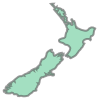

In [81]:
LandAreaPolygon_ne50

In [155]:
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

bounds = LandAreaPolygon_ne50.buffer(0.5).bounds
minX, minY, maxX, maxY = bounds


In [157]:
print bounds

(165.97825126184446, -47.13023025196303, 179.03622641970682, -33.92922667808582)


In [86]:
xres = 133
yres = 133

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T
mpt = MultiPoint(points=pts)


interior_mpts = mpt.intersection(LandAreaPolygon_ne50)
interior_points = np.array(interior_mpts)

fatBoundary = LandAreaPolygon_ne50.buffer(1.0) # A puffed up zone around the interior points
boundary = fatBoundary.difference(LandAreaPolygon_ne50)
inBuffer = mpt.intersection(boundary)

buffer_points = np.array(inBuffer)

## Make a new collection of points to stuff into a DM

ibmask = np.ones((interior_points.shape[0]), dtype=np.bool)
bbmask = np.zeros((buffer_points.shape[0]), dtype=np.bool)

bmask = np.hstack((ibmask, bbmask))
pts = np.vstack((interior_points, buffer_points))

# x1 = pts[:,0]
# y1 = pts[:,1]

SyntaxError: invalid syntax (<ipython-input-86-9c45335948ac>, line 20)

In [87]:
## Make a new collection of points to stuff into a DM

ibmask = np.ones((interior_points.shape[0]), dtype=np.bool)
bbmask = np.zeros((buffer_points.shape[0]), dtype=np.bool)

pts = np.vstack((interior_points, buffer_points))
bmask = np.hstack((ibmask, bbmask))


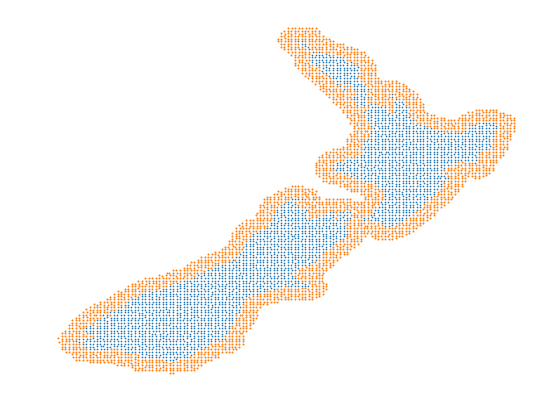

In [88]:
x1 = pts[:,0]
y1 = pts[:,1]

fig = plt.figure(1, figsize=(9,7))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(x1[bmask], y1[bmask], s=0.5)
ax.scatter(x1[~bmask], y1[~bmask], s=1.0)
plt.show()

In [135]:
gtiff = gdal.Open("../Notebooks/data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

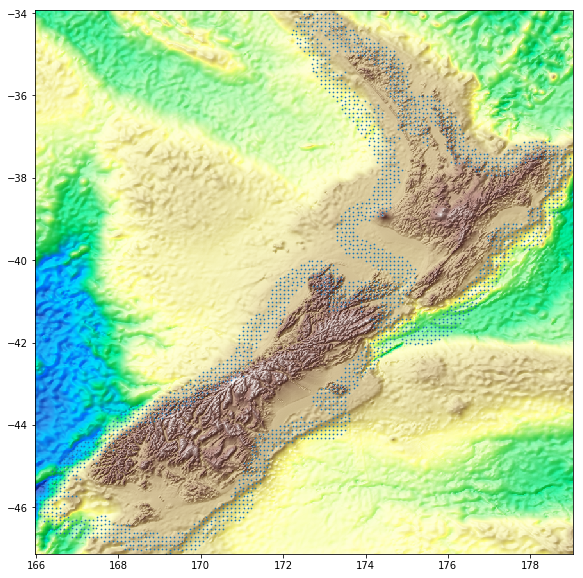

In [149]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1[~bmask], y1[~bmask], s=0.5)
plt.show()

In [124]:
coords = np.stack((y1, x1)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

array([-100., -100., -100., ..., -100., -100., -100.])

In [152]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = np.maximum(-100.0, meshheights)
#meshheights += 40.0 * (y1 - minY) / (maxY - minY)

#meshheights = mesh.rbf_smoother(meshheights, iterations=2)



In [153]:
submarine =  meshheights < 0.0


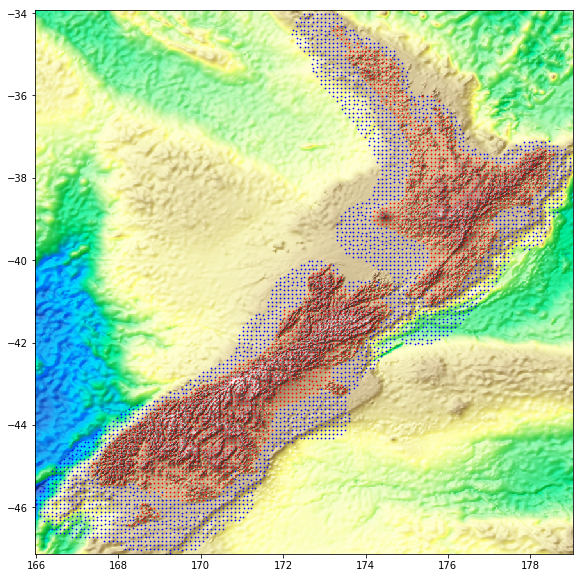

In [154]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1[submarine], y1[submarine], s=0.5, color="Blue")
ax.scatter(x1[~submarine], y1[~submarine], s=0.5, color="Red")


plt.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [28]:
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask, refinement_steps=2)

In [29]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True)
print "Points: ", mesh.npoints

0 - Delaunay triangulation 0.183812s
0 - Calculate node weights and area 0.005878s
0 - Find boundaries 0.00165s
0 - cKDTree 0.021509s
0 - Construct neighbour cloud array 0.607215s
0 - Construct rbf weights 0.176442s
Points:  130029


In [30]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [31]:
coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= img.shape[0] / (maxY-minY) 
im_coords[:,1] *= img.shape[1] / (maxX-minX) 

im_coords[:,0] =  img.shape[0] - im_coords[:,0]

In [32]:
print coords.shape
print bmaskr.shape
print bmaskr.nonzero()[0].shape


(130029, 2)
(130029,)
(122992,)


In [33]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(img, im_coords.T, order=3, mode='nearest')
meshheights = np.maximum(-100.0, meshheights)

meshheights = mesh.rbf_smoother(meshheights, iterations=2)
# meshheights = mesh.rbf_smoother(meshheights)
# meshheights = mesh.rbf_smoother(meshheights)



In [34]:
questionable = np.logical_and(bmaskr, meshheights < 10.0)
qindex = np.where(questionable)[0]

for index in qindex:
    point = Point(mesh.coords[index])
    if not AusLandPolygon_ne50.contains(point):
         bmaskr[index] =  False
    

In [144]:
## Fake geoid. This should perhaps be a struct on the surface mesh as it is not an actual height change !

# meshheightsG = meshheights + 40.0*(mesh.coords[:,0]-minX)/(maxX-minX) + 40.0*(mesh.coords[:,1]-minY)/(maxY-minY) 

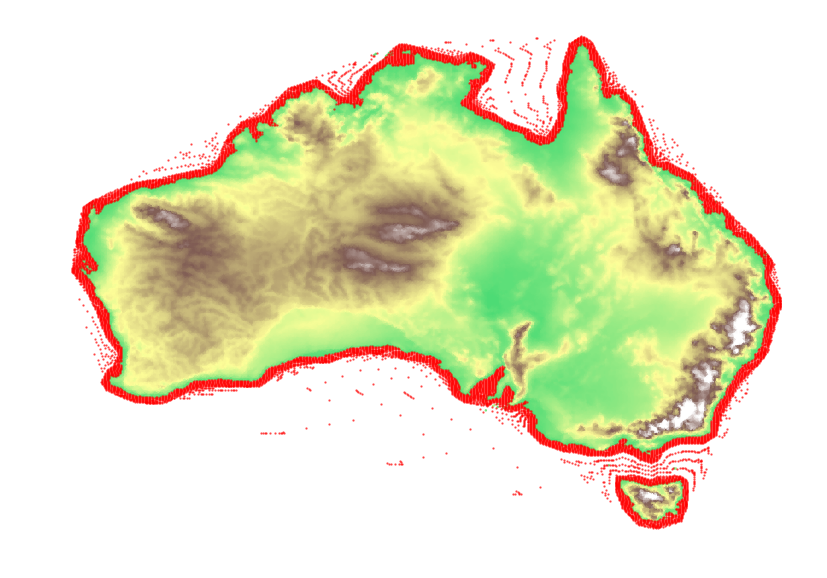

In [36]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[bmaskr], y2r[bmaskr], s=2, c=meshheights[bmaskr], cmap=cm.terrain, vmin=-500.0, vmax=1000)
sc = ax.scatter(x2r[~bmaskr], y2r[~bmaskr], s=2.0, c="Red", alpha=0.5)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
plt.show()

In [151]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)

flowpaths = mesh.cumulative_flow(np.ones_like(mesh.height))
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

 - Build downhill matrices 2.953121s


In [152]:
mesh.update_height(meshheightsG*0.001)

flowpathsG = mesh.cumulative_flow(np.ones_like(mesh.height))
flowpathsG2 = mesh.rbf_smoother(flowpathsG, iterations=1)

 - Build downhill matrices 2.958988s


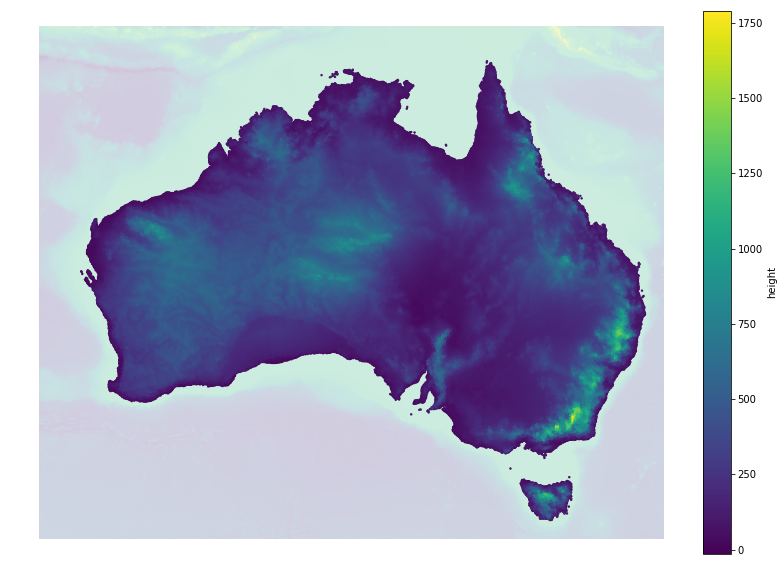

In [122]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(im_coords[bmaskr,1], im_coords[bmaskr,0], s=2, c=meshheights[bmaskr])
#sc = ax.scatter(im_coords[~bmaskr,1], im_coords[~bmaskr,0], s=2, c=meshheights[~bmaskr])
ax.imshow(img, alpha=0.25)

fig.colorbar(sc, ax=ax, label='height')
plt.show()


In [153]:
manifold = np.reshape(mesh.coords[bmaskr], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[bmaskr]*1.0, axis=1)

In [154]:
mesh.height.max()

1.7898243620557752

In [155]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[bmaskr], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[bmaskr]), label='flow')


topo3 = lv.points(pointsize=2.0, pointtype=0)
topo3.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

topo3.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap



2

In [156]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
lv.image(filename="AusFlow.png", resolution=(6000,4000))

'AusFlow.png'

In [28]:
# fig = plt.figure(1, figsize=(14, 10))
# ax = fig.add_subplot(111)
# ax.axis('off')

# sc = ax.scatter(x2r[bmaskr], y2r[bmaskr], s=1, c=mesh.height[bmaskr])
# ax.scatter(x2r[~bmaskr], y2r[~bmaskr], s=1, c=mesh.height[~bmaskr])

# fig.colorbar(sc, ax=ax, label='height')
# plt.show()

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [131]:
filename = 'austopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, slope=mesh.slope, flow=np.sqrt(flowpaths2))

# to view in Paraview
meshtools.generate_xdmf(filename)

In [157]:
mesh.neighbour_cloud.shape

(193011, 33)